In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/saved-model/Model.h5


## Reading Inputs

### Objective:
We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set using ML model.

### Input Files description
1. sales_train.csv - the training set. 
2. Daily historical data from January 2013 to October 2015.
3. test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
4. sample_submission.csv - a sample submission file in the correct format.
5. items.csv - supplemental information about the items/products.
6. item_categories.csv  - supplemental information about the items categories.
7. shops.csv- supplemental information about the shops.


### Data fields
1. ID - an Id that represents a (Shop, Item) tuple within the test set
2. shop_id - unique identifier of a shop
3. item_id - unique identifier of a product
4. item_category_id - unique identifier of item category
5. item_cnt_day - number of products sold. **(To Predict sales of product for upcoming month)**
6. item_price - current price of an item 
7. date - date in format dd/mm/yyyy
8. date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
9. item_name - name of item
10. shop_name - name of shop
11. item_category_name - name of item category



In [4]:
#reading Inputs
items_df=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
#items_df
items_df.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


In [3]:
item_categories_df=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops_df=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')


In [5]:
sales_train_df=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
sales_train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## Exploratory Data Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

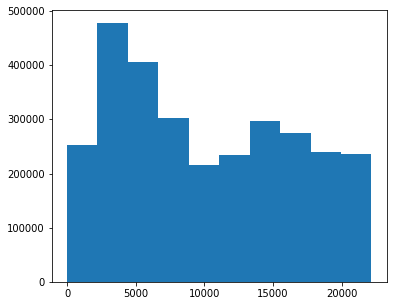

In [9]:
#distribution of item ID
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.hist(sales_train_df['item_id'])
plt.show

In [7]:
sales_train_df.groupby(['item_id']).nunique()

,date,date_block_num,shop_id,item_price,item_cnt_day
item_id,,,,,
0,1,1,1,1,1
1,6,5,1,1,1
2,2,2,1,1,1
3,2,2,1,2,1
4,1,1,1,1,1
...,...,...,...,...,...
22165,2,2,1,1,1
22166,270,25,1,1,4
22167,571,26,49,8,8


##### There are 21807 unique items

In [8]:
sales_train_df[['shop_id','item_id','item_price','item_cnt_day']].corr()

,shop_id,item_id,item_price,item_cnt_day
shop_id,1.000000,0.029396,-0.024034,-0.005230
item_id,0.029396,1.000000,-0.134104,0.016650
item_price,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,-0.005230,0.016650,0.011197,1.000000


No significant correlation between any 2 columns!

In [9]:
#EDA on train data
sales_train_df.groupby(['shop_id']).nunique()

,date,date_block_num,item_id,item_price,item_cnt_day
shop_id,,,,,
0,57,2,3600,621,11
1,56,2,2523,485,11
2,1018,34,4849,1114,33
3,1028,34,5261,1021,26
4,1010,34,7309,1258,31
5,996,33,7084,1182,28
6,1031,34,11856,2098,61
7,1034,34,8246,1594,38
8,84,4,1909,214,8


<function matplotlib.pyplot.show(close=None, block=None)>

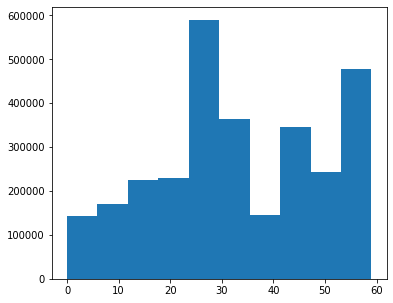

In [11]:
#Distribution of shop_id
plt.figure(figsize=(6,5))
plt.hist(sales_train_df['shop_id'])
plt.show

There are 59 unique shops

In [7]:
#Getting total sales of a shop for a unique date
sales_train_df.groupby(['shop_id','date_block_num']).sum('item_cnt_day')

item_id    item_price  item_cnt_day
shop_id date_block_num                                      
0       0               50791835  2.546339e+06        5578.0
        1               54019826  3.007530e+06        6127.0
1       0               28789014  1.378736e+06        2947.0
        1               32161359  1.547425e+06        3364.0
2       0               10025040  1.028861e+06        1146.0
...                          ...           ...           ...
59      29               8448873  7.877389e+05         913.0
        30               9285194  8.085937e+05         992.0
        31               9177292  8.235957e+05        1214.0
        32               7333448  8.829707e+05         914.0
        33               7232848  8.232262e+05         790.0

[1586 rows x 3 columns]

In [6]:
#Getting total sales of a shop for a unique item and date
#Transforming sales training set to required format as test.csv
sales_train_df_groupby=sales_train_df.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum().reset_index()

In [14]:
sales_train_df_groupby

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
...,...,...,...,...
1609119,59,22164,27,2.0
1609120,59,22164,30,1.0
1609121,59,22167,9,1.0
1609122,59,22167,11,2.0


### Findings of EDA:

1. There are 21807 unique items
2. There are 59 unique shops
3. No significant correlation between any 2 columns! 
4. Explored test data format and transformed the train data in the same way to get total sales of a shop for a unique item and date


1. **Inputs of Test.csv:shop_id,item_id** . 
2. **Output of Test.csv: item_cnt**. 

We'll use "sales_train_df_groupby" for training the model. We shall split this into train and validation set to test the model accuracy. Right now, i'm thinking of using a multi-linear or decision tree based regressor. We shall tets the model RMSE and the aim is to get score as close to 1.00 .  

## Linear Regression for Sales Prediction

In [16]:
#importing needed packages
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [15]:
#Getting X and Y variables
X = sales_train_df_groupby.drop(columns=['item_cnt_day','date_block_num'])#['date_block_num','shop_id']  # values converts it into a numpy array
Y = sales_train_df_groupby['item_cnt_day']  # -1 means that calculate the dimension of rows, but have 1 column

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train.head(2)

,shop_id,item_id
358394,19,3619
308964,17,3554


In [18]:
#Training and predicting for validation dataset
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, y_train)  # perform linear regression
Y_pred = linear_regressor.predict(X_test)  # make predictions

In [19]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, Y_pred)))

Mean Absolute Error: 1.738898169450526
Mean Squared Error: 56.71364315727616
Root Mean Squared Error: 7.530846111644837


RMSE is 7.5 which means model is having much deviation from the actual sale value. So, let's try Random forest regressor and xgboost techniques to predict sales value.

## **XGBoost Model**

In [20]:
item_cat_joined_df=items_df.merge(item_categories_df, on='item_category_id')

In [21]:
sales_train_df_groupby_cat_join=sales_train_df_groupby.merge(item_cat_joined_df, on='item_id')

In [22]:
sales_train_df_groupby_cat_join

,shop_id,item_id,date_block_num,item_cnt_day,item_name,item_category_id,item_category_name
0,0,30,1,31.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
1,1,30,1,10.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
2,2,30,2,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
3,2,30,5,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
4,2,30,15,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
...,...,...,...,...,...,...,...
1609119,59,9760,12,1.0,ВЕДЬМА (BD),37,Кино - Blu-Ray
1609120,59,12846,10,1.0,КОШКИ МЫШКИ (BD),37,Кино - Blu-Ray
1609121,59,16270,6,1.0,"Наш Сад, UPG с версии 6.0 до версии 10.0",75,Программы - Для дома и офиса
1609122,59,17732,9,1.0,Принц Персии. Prince of Persia (PC-DVD) (DVD-box),28,Игры PC - Дополнительные издания


In [23]:
Xgboost_X_train=sales_train_df_groupby_cat_join[['date_block_num','shop_id','item_id','item_category_id']]
Xgboost_X_train

,date_block_num,shop_id,item_id,item_category_id
0,1,0,30,40
1,1,1,30,40
2,2,2,30,40
3,5,2,30,40
4,15,2,30,40
...,...,...,...,...
1609119,12,59,9760,37
1609120,10,59,12846,37
1609121,6,59,16270,75
1609122,9,59,17732,28


In [24]:
Xgboost_Y_train=sales_train_df_groupby_cat_join[['item_cnt_day']]
Xgboost_Y_train

,item_cnt_day
0,31.0
1,10.0
2,1.0
3,1.0
4,1.0
...,...
1609119,1.0
1609120,1.0
1609121,1.0
1609122,1.0


In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(Xgboost_X_train, Xgboost_Y_train, test_size=0.2, random_state=123)

In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',max_depth = 10,  n_estimators = 100)
xg_reg.fit(X_train_xgb,y_train_xgb)

[15:54:36] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
preds = xg_reg.predict(X_test_xgb)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test_xgb, preds))
print("RMSE: %f" % (rmse))

RMSE: 4.868810


By using XGBoost, Now RMSE has further reduced to 4.68 from Linear regression's 7.65. So, XGBoost is much more efficient predicting sales price compared to Linear regression.

Now let's try using Random Forest regressor,Deep learning methods and Time series for much better accuracy.

## **Random Forest Regressor to predict sales**

In [31]:
#Random forest regressor model building
from sklearn.ensemble import RandomForestRegressor
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(Xgboost_X_train, Xgboost_Y_train, test_size=0.2, random_state=123)
RF_model = RandomForestRegressor()
RF_model.fit(X_train_rf, y_train_rf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor()

In [32]:
RF_pred=RF_model.predict(X_test_rf)

In [33]:
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, RF_pred))
print("RMSE: %f" % (rmse))

RMSE: 4.868810


Random forest and XGBoost are almost having same error predicting.

## **Time Series Analysis**

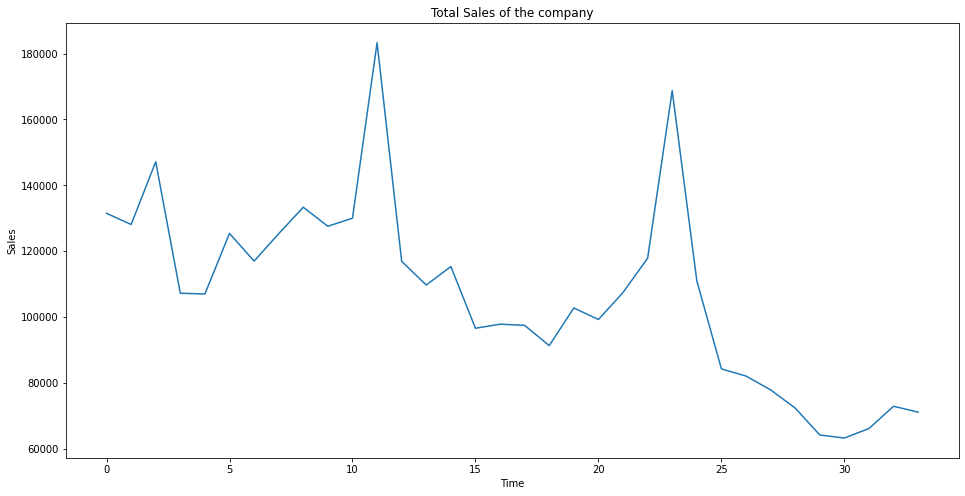

In [10]:
ts=sales_train_df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

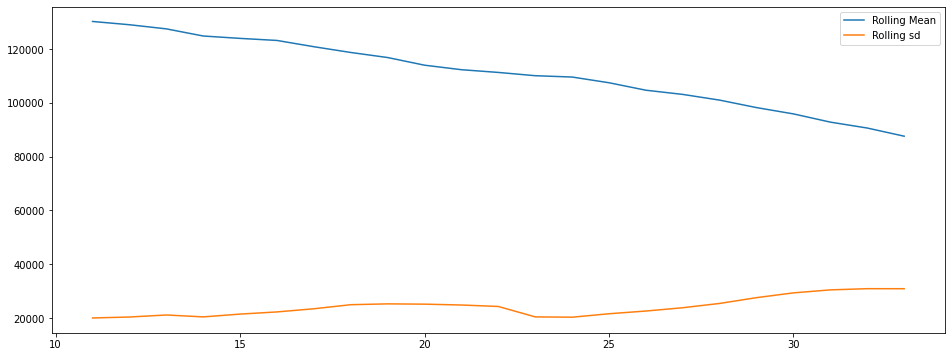

In [11]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:** There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

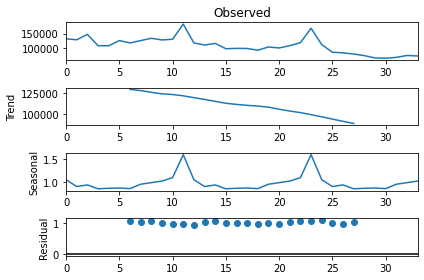

In [12]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

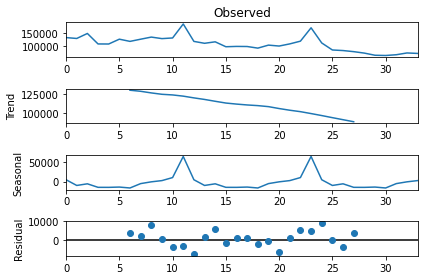

In [14]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

There is seasonality and residual plot is not random and seems to follow a pattern. Lets check if series is non-stationary. We shall do ADF stationarity test.

In [15]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [16]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


##### our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series.

### ARMA models:

MA - Next value in the series is a function of the average of the previous n number of values AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values ARMA - a mixture of both.

Now, How do we find out, if our time-series in AR process or MA process?

Let's find out!

In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


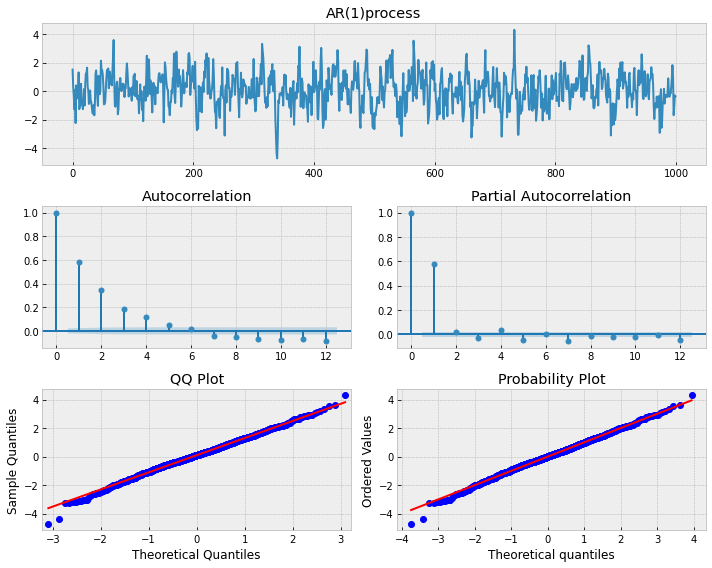

In [21]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

##From the graph it's visible that ACF tails out and PACF cuts at lag1

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


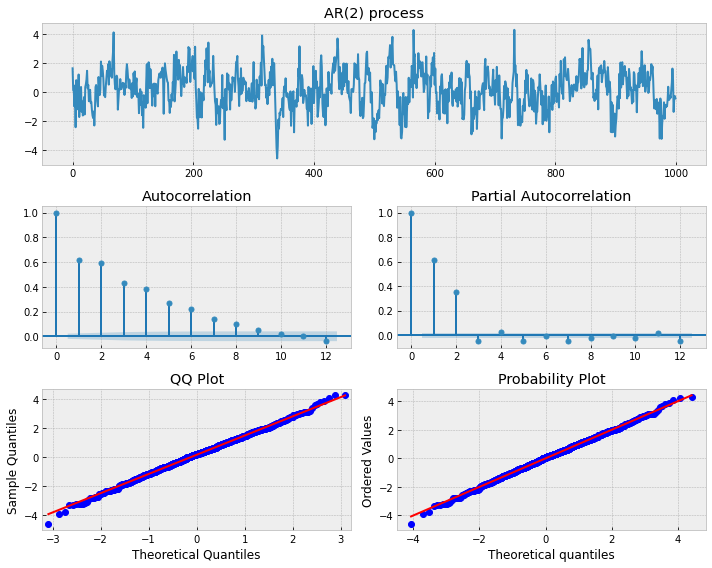

In [19]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


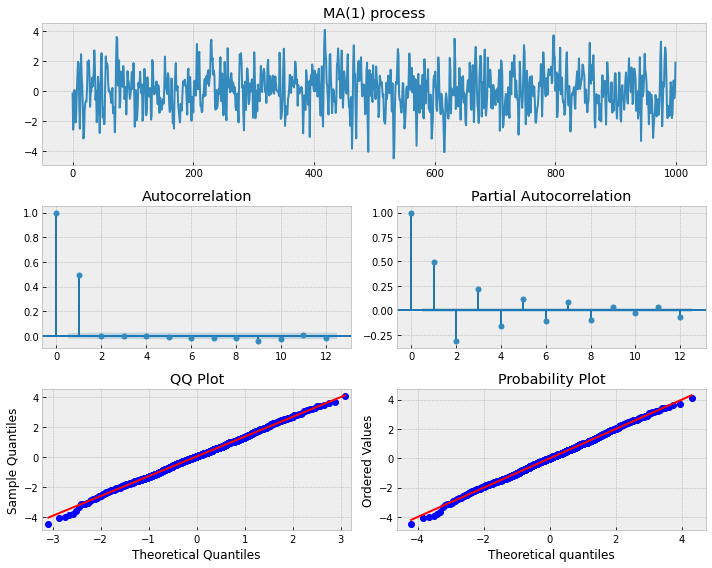

In [20]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


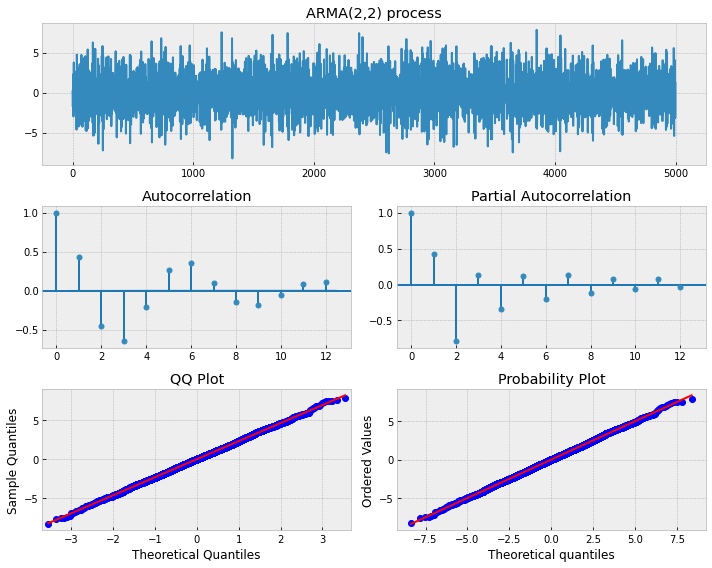

In [22]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## **DEEP LEARNING METHOD**

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from sklearn.model_selection import KFold,GroupKFold
from tensorflow.keras import layers

In [24]:
from sklearn.preprocessing import RobustScaler,StandardScaler

sc = StandardScaler()

In [25]:
dataset=[]
dataset = sales_train_df.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [26]:
test_df=pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [27]:
dataset.reset_index(inplace = True)


In [28]:
dataset = pd.merge(test_df,dataset,on = ['item_id','shop_id'],how = 'left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [29]:
dataset.fillna(0,inplace = True)

In [31]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)

In [32]:
dataset.shape

(214200, 34)

In [33]:
# X we will keep all columns execpt the last one 
X_train_deep = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train_deep = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test_deep = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train_deep.shape,y_train_deep.shape,X_test_deep.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [34]:
save_best = tf.keras.callbacks.ModelCheckpoint("Model.h5", monitor='val_loss',verbose=1, save_best_only=True)

In [35]:
def build_model():
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(33, 1)))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='uniform'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = 'mse', metrics=['mse'])

    model.summary()
    
    return model

In [36]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 33, 256)           133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 33, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 33, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4224)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                135200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 432,705
Trainable params: 432,705
Non-trainable params: 0
__________________________________________________

In [ ]:
#Run/Fit model only for first time and save the model details in Model.H5 for future use
#as it takes around 4-5 hrs for the model to fit the data
#Use saved Model.H5 for predicting future sales
##model.fit(X_train_deep, y_train_deep, validation_split=0.2, epochs=40, batch_size=512, verbose=1, callbacks=[save_best])

In [ ]:
#run this for first time while building the model for first time
#model.evaluate(X_train_deep, y_train_deep)

RMSE of Deep learning model comes out to be **1.03651** which is very much less than Other basic models that was tried. This means Deep learning model can learn complex patterns and can predict future sales more accurately than ML models.

In [37]:
model = tf.keras.models.load_model('../input/saved-model/Model.h5')

In [38]:
# creating submission file 
submission = model.predict(X_test_deep, verbose=1)
# we will keep every value between 0 and 20
submission = submission.clip(0,20)


6694/6694 [==============================] - 185s 27ms/step


In [39]:
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test_df['ID'],'item_cnt_month':submission.ravel()})
# creating csv file from dataframe
submission.to_csv('submission.csv',index = False)

### Conclusion:

In this notebook i had tried to predict sales of different items at shop level using different ML techniques. To summarize:
  1. RMSE of Linear Regression:7.65
  2. RMSE of XG Boost:4.68 
  3. RMSE of Random FOrest Regressor:4.86
  4. RMSE of LSTM model:1.03
  
This means Deep learning model can learn complex patterns and can predict future sales more accurately than ML models.

### Next Steps:

Further the Deep learning model can be tuned on hyper parameters to get much better results and to improve accuracy.